In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from domid.arg_parser import mk_parser_main
os.chdir('../')
print("Current working directory:", os.getcwd())

Current working directory: /storage2T/github/DomId


# Some Helper functions that are going to be useful for the analysis of the experimental results

*  `get_most_recent_directory(directory)` takes a directory path as input, retrieves a list of directories within it, sorts them by their creation time in descending order, and returns the path of the most recently created directory. That is how we will obtain the repo with the results for the latest experiment.
* `load_files ` reads a CSV file named "clustering_results.csv" located at the specified path of the experimnet. It then extracts specific columns from the results DataFrame that are used to analyze results.
* `something_per_domain` takes two arrays as input: domain, representing predicted domain labels, and another_label, representing some other label corresponding to each predicted domain label. It calculates the counts of occurrences of combination of predicted domain and another labels (e.g how many red digits in domain 0).
*  `plot_something_per_domain_proportion` generates a bar graph illustrating the proportion of counts for each unique label within each predicted domain.

In [2]:

def get_most_recent_directory(directory):
    try:
        directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        directories.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
        return os.path.join(directory, directories[0])
    except Exception as e:
        print("Error:", e)
        return None



In [3]:

def load_files(path):
    df = pd.read_csv(os.path.join(path, 'clustering_results.csv'))
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(os.path.join(path, "Z_space.npy"))
    model_name = path.split('_')[-1]

    #args = np.loadtxt(path + "arguments.txt", dtype=str, usecols=0)  # , delimiter = '\n')
    #img_locs = np.loadtxt(path + "img_id.txt", dtype=str)
    
    return domain, vec_d, vec_y, img_locs, model_name

In [4]:
def something_per_domain(domain, another_label):
    """
    domain - predicted domain labels 
    another_label - some other label that corresponds to each of the predicted domain (
    assumed that both domain and something have the same img_loc reference order 
    """
    u_something = np.unique(another_label)
    u_domain = np.unique(domain)
    print('unique predicted domain', u_domain)
    print('unique true label', u_something)
    
    array_counters=[]
    for i in u_domain:
        for j in u_something:
            counter = 0
            for idx in range(0, len(domain)):
                if domain[idx]==i and another_label[idx]==j:
                    counter+=1
            
            array_counters.append(counter)
    return array_counters

In [5]:
def plot_something_per_domain_proportion(domain, another_label, counts, fs, legend = False, thres = None, title = None, digit_plot = True):
    """
    domain - predicted domain labels
    another_label - another label aassociated with each predicted domain (should be same shape as domain)
    counts - countes of each another label in each of the predicted domain (see something_per_domain function)
    fs - font size
    colors - colors of each segment on the bargraph
    legend - legend of unique another lables
    thres - if thresholding of another label is required then should be shpecifies (also see apply_threshold function)
    
    """
    u_domains = np.unique(domain)
    N = len(u_domains)
    
    u_another_label = np.unique(another_label)
    print('unique labels', u_another_label)
    print(u_domains)
    counts = np.array(counts)
    narray = np.array_split(counts, N)

    if thres:
        u_another_label_dic = apply_threshold(u_another_label, narray, thres, N)
        #print(u_another_label_dic.values())
        u_another_label = list(u_another_label_dic.keys())
        narray = list(u_another_label_dic.values())
        narray = np.transpose(narray)

   # print(narray)
    #print(len(u_domains), len(u_another_label))
    # c = ['blue', 'teal', 'pink', 'orange', 'green', 'red', 'plum', 'grey', 'purple', 'yellow']
    # c = ['lightblue', 'steelblue', 'royalblue', 'mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown']
    
    if digit_plot:
        c =  ['darkseagreen', 'forestgreen', 'aquamarine', 'lightseagreen', 'teal', 'steelblue','lightblue', 'royalblue','navy', 'lightslategrey' ]

    else:
        c = ['mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown', 'peachpuff', 'goldenrod', 'gold']
  
        
    plt.figure(figsize = (5, 5))
    for i in range(0, len(u_domains)):
        for jj in range(0,len(u_another_label)):
            
            if jj>0:
                bottom = np.sum(narray[i][:jj])/np.sum(narray[i])
            else:
                bottom = 0
            ##print(i, narray[i][jj])
            #print(c[jj])
            plt.bar(i, narray[i][jj]/np.sum(narray[i]), bottom = bottom, color = c[jj])
    x = np.linspace(0, N-1, N)
    x_ticks = [str(item) for item in u_domains]
    #plt.ylabel("Proportion", fontsize=fs)
    plt.xticks(x, x_ticks, fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel("Domain", fontsize=fs)
    plt.title(title, fontsize = fs, weight = 'bold')
    plt.tick_params(left = False, labelleft = False)
    if legend:
        plt.legend(legend, bbox_to_anchor=(0.5, 10))
    else:
        plt.legend(u_another_label, bbox_to_anchor=(1, 1.1), fancybox=True, shadow=True, fontsize = fs)
    plt.show()

# VaDE with Colored MNIST 

In [6]:
from domid.mk_exp import mk_exp

First, we initialize an experiment, specifying the model, task (including the dataset definition), trainer, and various hyperparameters.

In [7]:
exp = mk_exp(task='mnistcolor10', model='vade', 
             trainer='cluster',
             train_domain = '0 1 2 3 4 5 6 7 8 9', 
             test_domain='0', prior="Gaus", 
             batchsize = 2, pre_tr=2, epos=20, model_method="cnn")
# Note that by default the experiment, including DL training, will be performed on CPU. To use GPU/CUDA, pass `nocu=False` as an additional argument to mk_exp.

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=0.0001, gamma_reg=0.1, es=1, seed=0, nocu=True, device=None, gen=False, keep_model=False, epos=20, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='zdpath', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='mnistcolor10', bs=2, split=0, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=64, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, nperm=

/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets



using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=64, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=64, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=64, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S




!!!: not committed yet
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'cda60d9'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: mnistcolor10_te_rgb_31_119_180_vade_bcda60d9_not_commited_2024md_03md_12_07_20_05_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


We execute the experiment to run the training of the deep clustering algorithm, and to store the results.

In [8]:
exp.execute()


 Experiment start at : 2024-03-12 07:20:05.269089
before training, model accuracy: (0.12333333333333334, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [510, 610, 570, 670, 540, 680, 570, 530, 740, 580],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]), 0.1, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
  

/storage2T/github/DomId/domid/utils/storing.py:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/storage2T/github/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


After the experiment has finished, we can find the saved results files.

In [9]:
directory = "./notebooks"
vade_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: ', vade_results_path)

Results from the following folder are going to be analyzed:  ./notebooks/2024-03-12_07:20:05.226058_mnistcolor10_vade


We load the results from disk.

In [10]:
domain, vec_d, vec_y, img_locs, model_name = load_files(vade_results_path)
color = vec_d
digit = vec_y
model_name = 'VaDE'

In [11]:
digits_per_domain = something_per_domain(domain, digit)

unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]


In [12]:
colors_per_domain = something_per_domain(domain, color)

unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]


Finally, we can make some visualizations of the results.

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


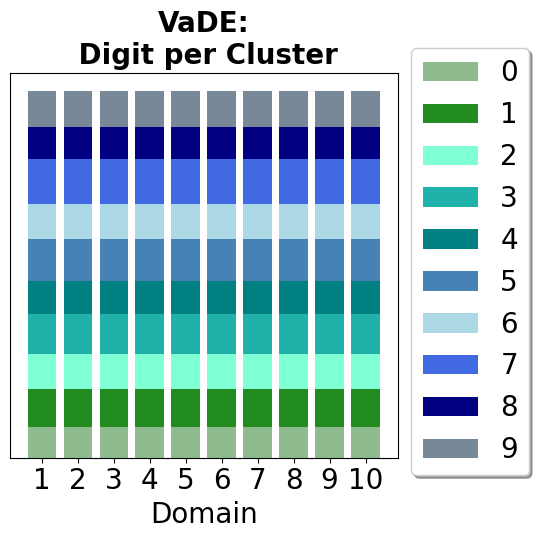

In [13]:
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


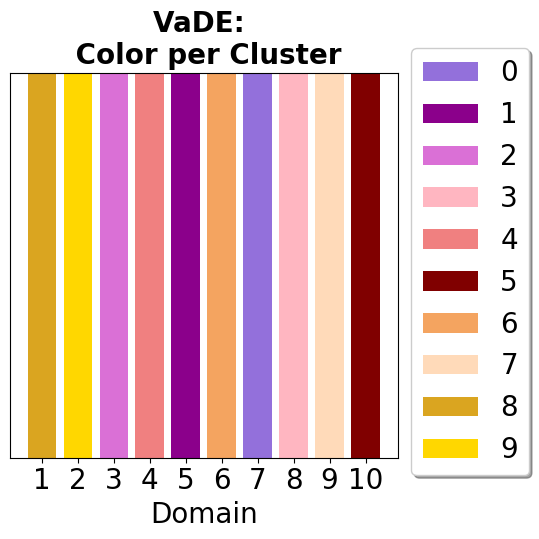

In [14]:
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 

# DEC with Colored MNIST 

In [15]:
from domid.mk_exp import mk_exp
exp = mk_exp(task='mnistcolor10', model='dec', 
             trainer='cluster',
             train_domain = '0 1 2 3 4 5 6 7 8 9', 
             test_domain='0', prior="Gaus",
             batchsize = 2, pre_tr=2, epos=20,
             model_method="cnn", nocu=False)
exp.execute()
# Note that by default the experiment, including DL training, will be performed on CPU. To use GPU/CUDA, you need to pass `nocu=False` to mk_exp.

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=0.0001, gamma_reg=0.1, es=1, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=20, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='zdpath', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='dec', acon=None, task='mnistcolor10', bs=2, split=0, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=64, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, nperm=

/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets



using device: cuda

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets
no split between train and test datasets





!!!: not committed yet
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'cda60d9'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: mnistcolor10_te_rgb_31_119_180_dec_bcda60d9_not_commited_2024md_03md_12_08_15_28_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________

 Experiment start at : 2024-03-12 08:15:28.474651
before training, model accuracy: (0.12333333333333334, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [510, 740, 610, 570, 670, 540, 680, 570, 530, 580],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]), 0.1, array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [600, 600, 600, 600, 600, 600, 600, 

/storage2T/github/DomId/domid/utils/storing.py:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/storage2T/github/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


After the experiment has finished, we can find and load the results from disk.

In [16]:
directory = "./notebooks"
dec_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: ', dec_results_path)

domain, vec_d, vec_y, img_locs, model_name = load_files(dec_results_path+'/')
color = vec_d
digit = vec_y
model_name ='DEC'

Results from the following folder are going to be analyzed:  ./notebooks/2024-03-12_08:15:28.433472_mnistcolor10_dec


And we make some visualizations of the results.

unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


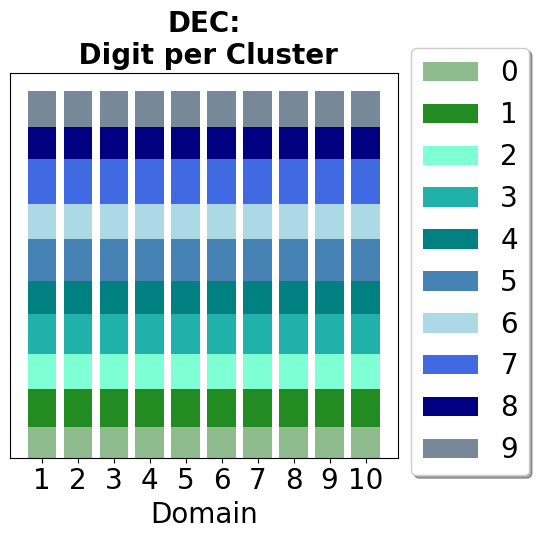

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


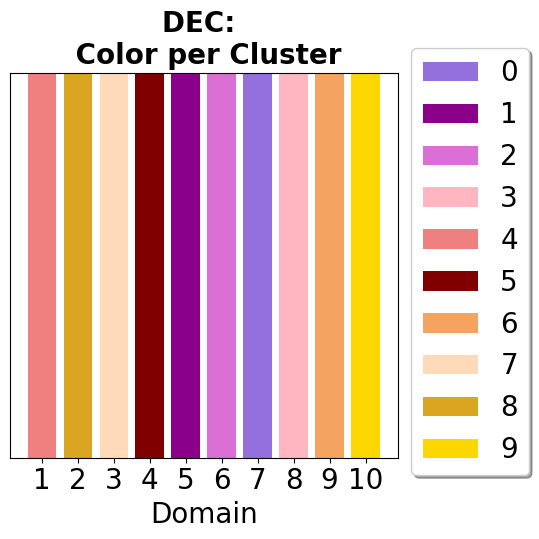

In [17]:
digits_per_domain = something_per_domain(domain, digit)
colors_per_domain = something_per_domain(domain, color)
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 

# CDVaDE for Colored MNIST 

Define and run the experiment:

In [18]:
from domid.mk_exp import mk_exp
exp = mk_exp(task='mnistcolor10', model='vade', 
             trainer='cluster',
             train_domain = '0 1 2 3 4 5 6 7 8 9', 
             test_domain='0', 
             batchsize = 2, pre_tr=10, epos=80, zd_dim=20,
             inject_var = 'color', dim_inject_y = 10,
             nocu=False, d_dim=10, lr=0.0005, split=0.8, L=5,
             prior="Gaus", model_method="cnn", subset_step=1)
exp.execute()

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=0.0005, gamma_reg=0.1, es=1, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=80, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='zdpath', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='mnistcolor10', bs=2, split=0.8, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=20, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, npe

/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets



using device: cuda

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=20, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=20, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=30, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S




!!!: not committed yet
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'cda60d9'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: mnistcolor10_te_rgb_31_119_180_vade_bcda60d9_not_commited_2024md_03md_12_08_42_07_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________

 Experiment start at : 2024-03-12 08:42:07.901304
before training, model accuracy: (0.12458333333333334, array([[598, 421, 481, 451, 538, 434, 536, 450, 417, 474],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]), 0.1, array([[480, 480, 480, 480, 480, 480, 480, 480, 480, 480],
       [  0,   0,   0,   0,   0,   0,   0, 

/storage2T/github/DomId/domid/utils/storing.py:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/storage2T/github/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


Visualize some of the results:

Results from the following folder are going to be analyzed: 
 ./notebooks/2024-03-12_08:42:07.859322_mnistcolor10_vade
unique predicted domain [ 1  2  3  4  5  6  7  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique predicted domain [ 1  2  3  4  5  6  7  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  9 10]


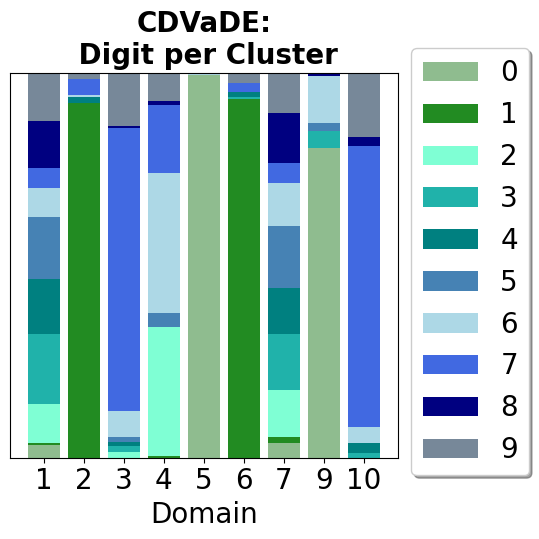

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  9 10]


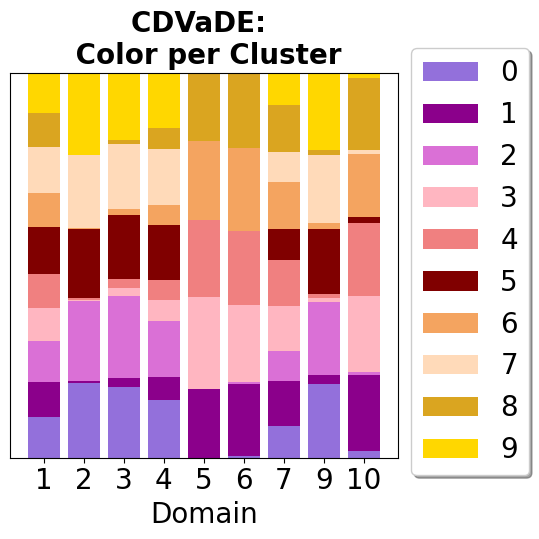

In [19]:
directory = "./notebooks"
cdvade_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: \n', cdvade_results_path)

domain, vec_d, vec_y, img_locs, model_name = load_files(cdvade_results_path+'/')
color = vec_d
digit = vec_y
model_name = 'CDVaDE'

digits_per_domain = something_per_domain(domain, digit)
colors_per_domain = something_per_domain(domain, color)
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 

# CDVaDE for Colored MNIST 

Define and run the experiment:

In [18]:
from domid.mk_exp import mk_exp
exp = mk_exp(task='mnistcolor10', model='vade', 
             trainer='cluster',
             train_domain = '0 1 2 3 4 5 6 7 8 9', 
             test_domain='0', 
             batchsize = 2, pre_tr=10, epos=400, zd_dim=20,
             inject_var = 'color', dim_inject_y = 10,
             nocu=False, d_dim=10, lr=0.0005, split=0.8, L=5,
             prior="Gaus", model_method="cnn", subset_step=1)
exp.execute()

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=0.0005, gamma_reg=0.1, es=1, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=400, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='zdpath', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='mnistcolor10', bs=2, split=0.8, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=20, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, np

/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets



using device: cuda

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=20, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=20, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=30, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S




!!!: not committed yet
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'54e77c6'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: mnistcolor10_te_rgb_31_119_180_vade_b54e77c6_not_commited_2024md_03md_11_09_13_26_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________

 Experiment start at : 2024-03-11 09:13:26.095644
before training, model accuracy: (0.12229166666666667, array([[587, 407, 498, 456, 539, 432, 537, 470, 421, 453],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]), 0.1, array([[480, 480, 480, 480, 480, 480, 480, 480, 480, 480],
       [  0,   0,   0,   0,   0,   0,   0, 

/storage2T/github/DomId/domid/utils/storing.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/storage2T/github/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


Visualize some of the results:

Results from the following folder are going to be analyzed: 
 ./notebooks/2024-03-11 09:13:26.059117_mnistcolor10_vade
unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


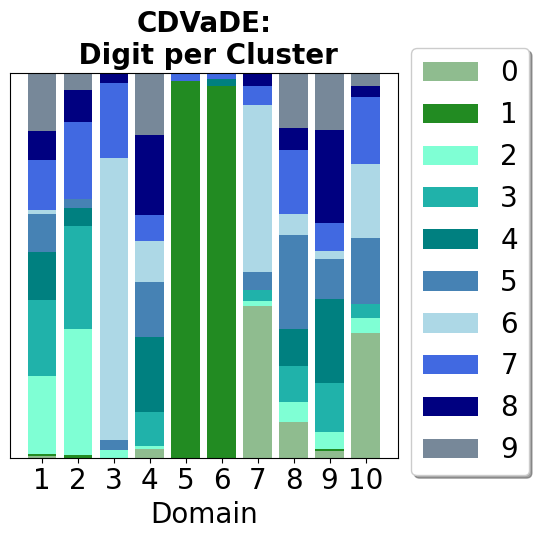

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


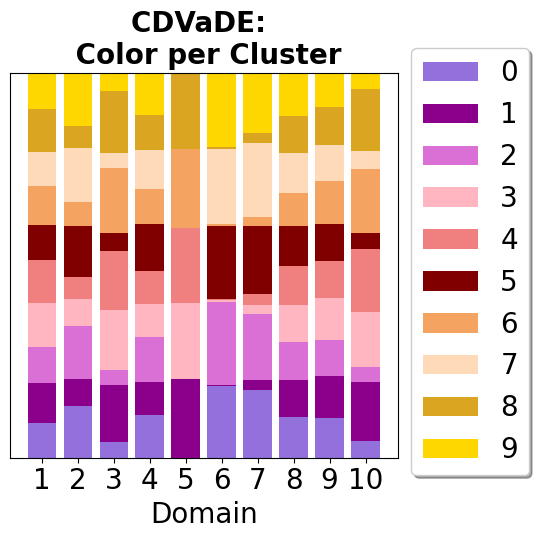

In [19]:
directory = "./notebooks"
cdvade_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: \n', cdvade_results_path)

domain, vec_d, vec_y, img_locs, model_name = load_files(cdvade_results_path+'/')
color = vec_d
digit = vec_y
model_name = 'CDVaDE'

digits_per_domain = something_per_domain(domain, digit)
colors_per_domain = something_per_domain(domain, color)
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 